In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

from numpy import random
import datetime
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
file_path = r'C:\Users\General\Desktop\CAPSTONE\Datasets\timeseries1.csv'
# C:\Users\General\Desktop\MSc Data Science\CAPSTONE\Datasets

a = pd.read_csv(file_path)
a

,date,value1,value2
0,01-01-2022,-0.601368,0.441227
1,02-01-2022,0.319782,-0.330870
2,03-01-2022,-1.592994,2.430771
3,04-01-2022,0.440475,-0.252092
4,05-01-2022,-0.019638,0.109610
...,...,...,...
295,23-10-2022,-3.760809,-2.509073
296,24-10-2022,-3.525656,-1.104999
297,25-10-2022,-0.737416,-2.176203
298,26-10-2022,-2.551858,-1.653917


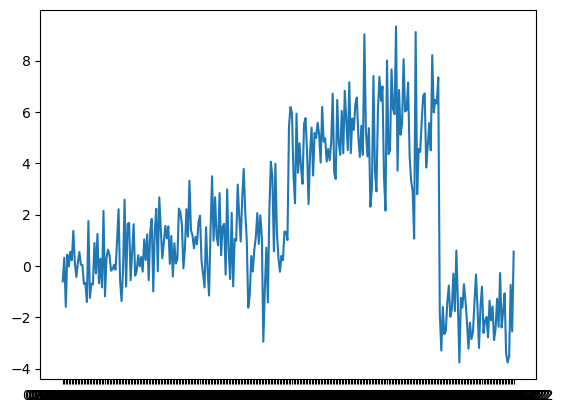

In [3]:
plt.plot(a['date'], a['value1'])
plt.show()

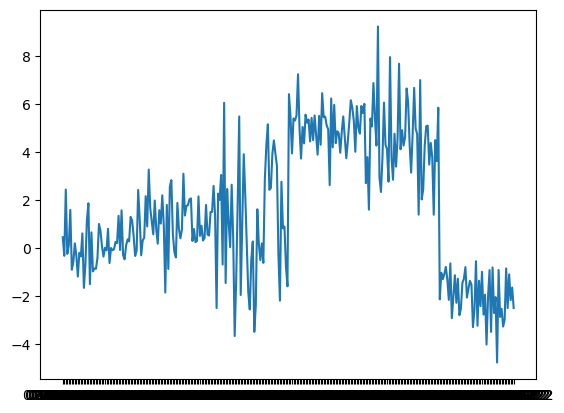

In [4]:
plt.plot(a['date'], a['value2'])
plt.show()

In [5]:
y = a['value1']

In [6]:
type(y)

pandas.core.series.Series

In [7]:
class CusumDetector:
    
    def __init__(self, t_warmup = 30, p_limit= 0.01):
        self._t_warmup = t_warmup
        self._p_limit = p_limit
        self._reset()
        
    def predict_next(self, y):
        self._update_data(y)
        
        if self.current_t == self._t_warmup:
            self._init_params()
            
        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            
            if is_changepoint:
                self._reset()
                
            return (1-prob), is_changepoint
        
        else:
            return 0, False
        
    def _reset(self):
        self.current_t = 0
        self.current_obs = []
        self.current_mean = None
        self.current_std = None
        
    def _update_data(self, y):
        self.current_t += 1
        self.current_obs.append(y)

    def _init_params(self):
        self.obs = pd.Series(self.current_obs)
        f = Fitter(self.obs, distributions=["norm"])
        f.fit()
        self.current_mean = f.fitted_param["norm"][0]
        self.current_std = f.fitted_param["norm"][1]
        
    def _check_for_changepoint(self):
        standardized_sum = (np.sum(self.current_obs) - (self.current_t * self.current_mean)) / (self.current_std * self.current_t**0.5)
        prob = float(self._get_prob(standardized_sum))
        
        return prob, prob < self._p_limit
    
    def _get_prob(self, y):
        p = norm.cdf(np.abs(y))  # 0.5 * (1 + np.math.erf(np.abs(y) / np.sqrt(2)))
        prob = 2 * (1 - p)
        
        return prob
    
    def extract_prob_checkpoint_sep(self, y):
        
        self._reset()
        ret_val = [test.predict_next(y[i]) for i in range(len(y))]
        cps = np.where(list(map(lambda x: x[1], ret_val)))[0]
        probs = np.array(list(map(lambda x: x[0], ret_val)))
        
        return probs, cps
    
    def extract_prob_checkpoint(self, y):
        
        self._reset()
        ret_val = [test.predict_next(y[i]) for i in range(len(y))]
        
        return ret_val
    
    def plot_contour_checkpoint(self, y):
        
        self._reset()
        outs = [test.predict_next(y[i]) for i in range(len(y))]
        
        cps = np.where(list(map(lambda x: x[1], outs)))[0]
        probs = np.array(list(map(lambda x: x[0], outs)))
        
        print(cps)
        
        # Plot results
        X, Y = np.meshgrid(np.arange(len(y)), np.linspace(-11, 11))
        Z = probs[X]

        plt.figure(figsize=(18, 9))
        plt.contourf(X, Y, Z, alpha=0.3, cmap="Reds")
        plt.plot(np.arange(len(y)), y, lw=0.75, label="Data", color="blue")

        # Plot detected changepoints
        [plt.axvline(cp, color="red", linestyle="dashed", lw=2) for cp in cps]

        plt.grid(alpha=0.75, linestyle="dotted", lw=2)
        plt.legend()
        plt.title("CUSUM Results")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.show()
    
    def plot_checkpoint(self, y):
        
        self._reset()
        outs = [test.predict_next(y[i]) for i in range(len(y))]
        
        cps = np.where(list(map(lambda x: x[1], outs)))[0]
        
        print(cps)
        
        plt.figure(figsize=(18, 9))
        plt.plot(np.arange(len(y)), y, lw=0.75, label="Data", color="blue")

        # Plot detected changepoints
        [plt.axvline(cp, color="red", linestyle="dashed", lw=2) for cp in cps]

        plt.grid(alpha=0.75, linestyle="dotted", lw=2)
        plt.legend()
        plt.title("CUSUM Results")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.show()
        
    def process_single_column(self, df, column):
        y = df[column]
        self._reset()
        return [self.plot_checkpoint(y)]
    
    def plot_cusum(self, df, columns):
        results = {}
        for column in columns:
            self.process_single_column(df, column)
            results[column] = self.extract_prob_checkpoint_sep(df[column])[1]
        return results

In [8]:
# Initialize CUSUM detector
test = CusumDetector()

2024-07-08 14:12:52.861 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-07-08 14:12:52.905 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-07-08 14:12:52.955 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-07-08 14:12:52.993 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-07-08 14:12:53.024 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)


[ 64 154 212 255]


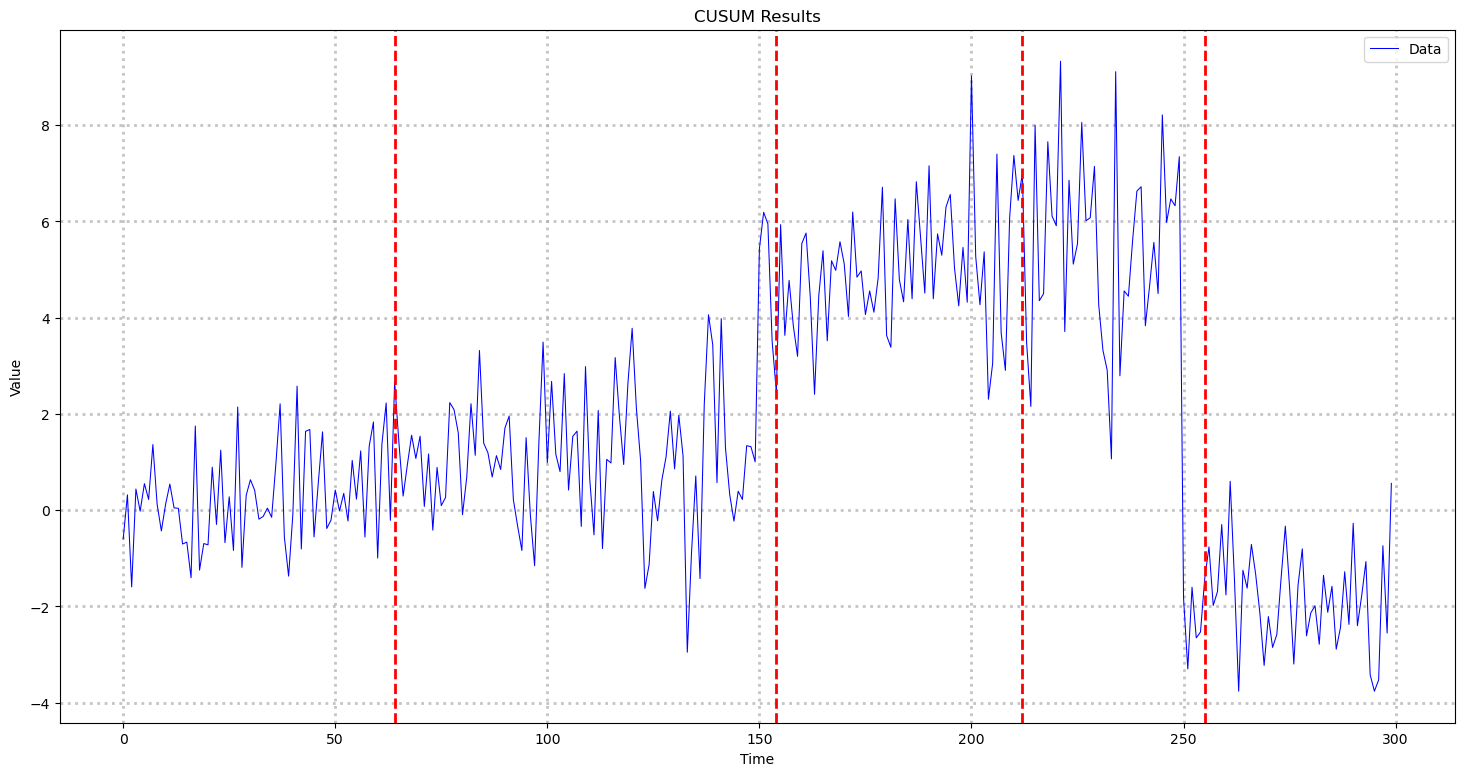

In [9]:
test.plot_checkpoint(y)

2024-07-08 14:12:53.537 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-07-08 14:12:53.580 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-07-08 14:12:53.634 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-07-08 14:12:53.671 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-07-08 14:12:53.700 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)


[ 64 154 212 255]


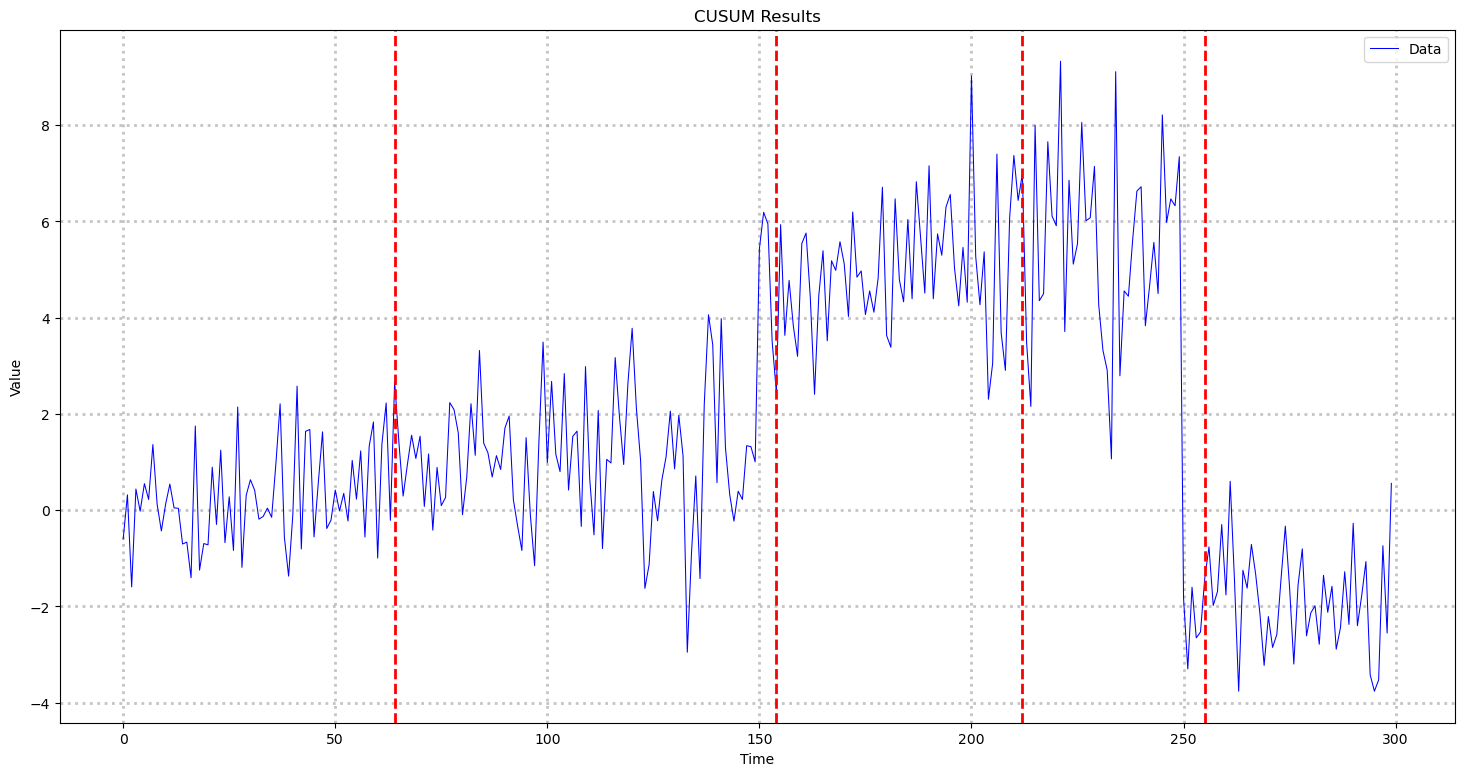

2024-07-08 14:12:54.142 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-07-08 14:12:54.190 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-07-08 14:12:54.237 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-07-08 14:12:54.279 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-07-08 14:12:54.309 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)
2024-07-08 14:12:54.341 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=16.368181)
2024-07-08 14:12:54.377 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=11.981057)
2024-07-08 14:12:54.431 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm dist

[ 59 156 250]


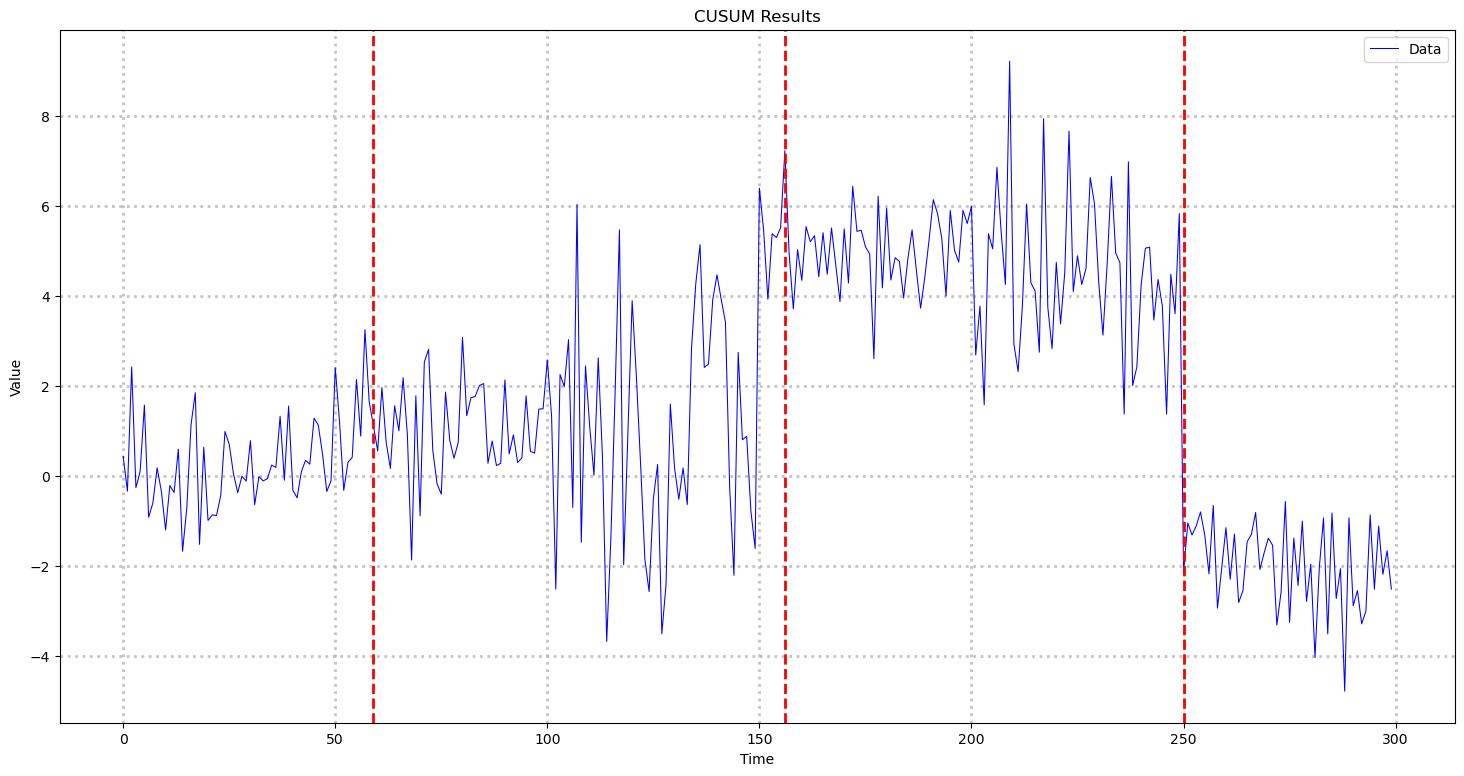

2024-07-08 14:12:54.906 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=16.368181)
2024-07-08 14:12:54.943 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=11.981057)
2024-07-08 14:12:54.990 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=18.893876)
2024-07-08 14:12:55.043 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=43.929834)


Results for value1: [ 64 154 212 255]
Results for value2: [ 59 156 250]


In [10]:
# Process multiple columns
results = test.plot_cusum(a, ['value1', 'value2'])
for column, result in results.items():
    print(f"Results for {column}: {result}")

2024-07-08 14:12:55.095 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-07-08 14:12:55.131 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-07-08 14:12:55.178 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-07-08 14:12:55.221 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-07-08 14:12:55.262 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)


[ 64 154 212 255]


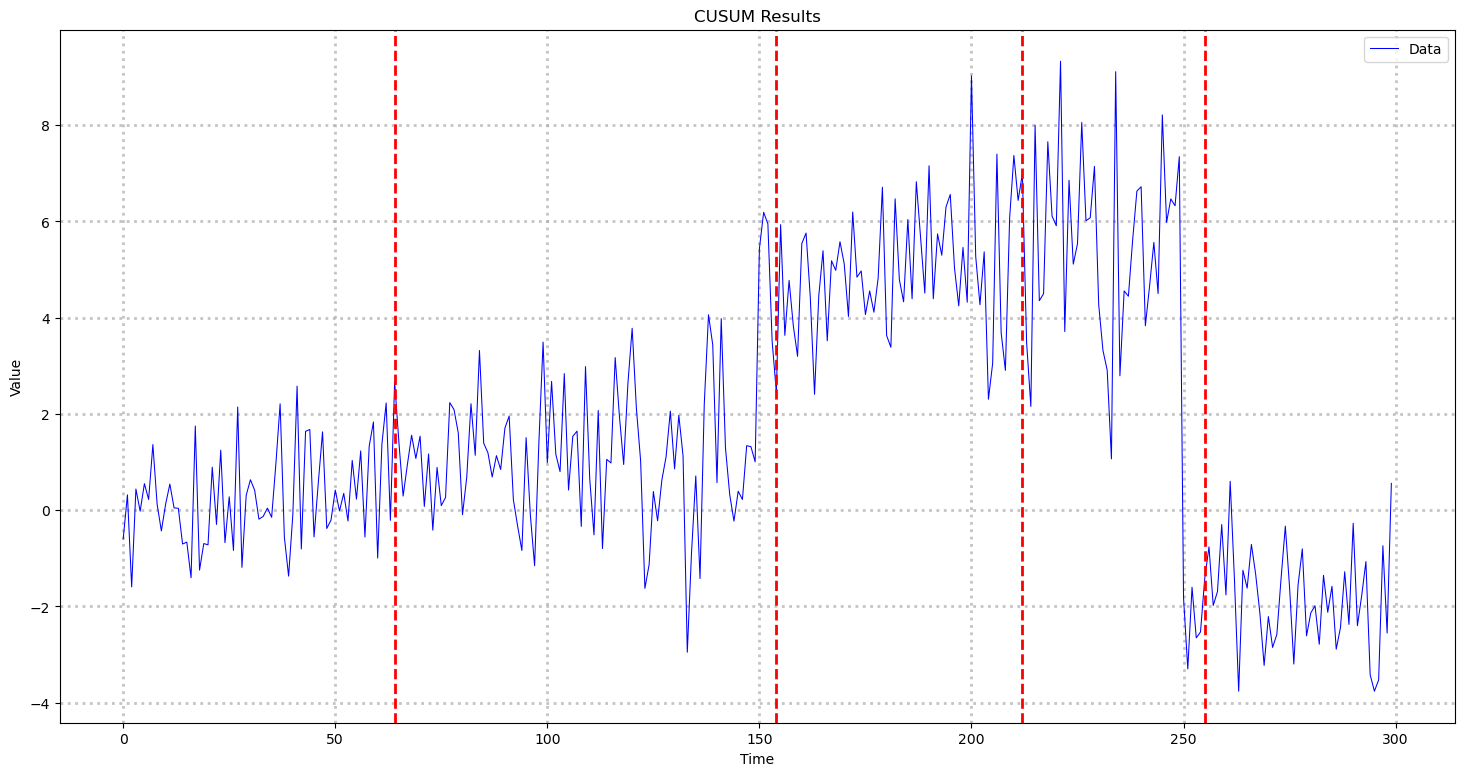

2024-07-08 14:12:55.697 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-07-08 14:12:55.742 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-07-08 14:12:55.796 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-07-08 14:12:55.830 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-07-08 14:12:55.871 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)


{'value1': array([ 64, 154, 212, 255], dtype=int64)}

In [11]:
test.plot_cusum(a, ['value1'])

2024-07-08 14:13:32.972 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=16.368181)
2024-07-08 14:13:33.020 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=11.981057)
2024-07-08 14:13:33.070 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=18.893876)
2024-07-08 14:13:33.117 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=43.929834)


[ 59 156 250]


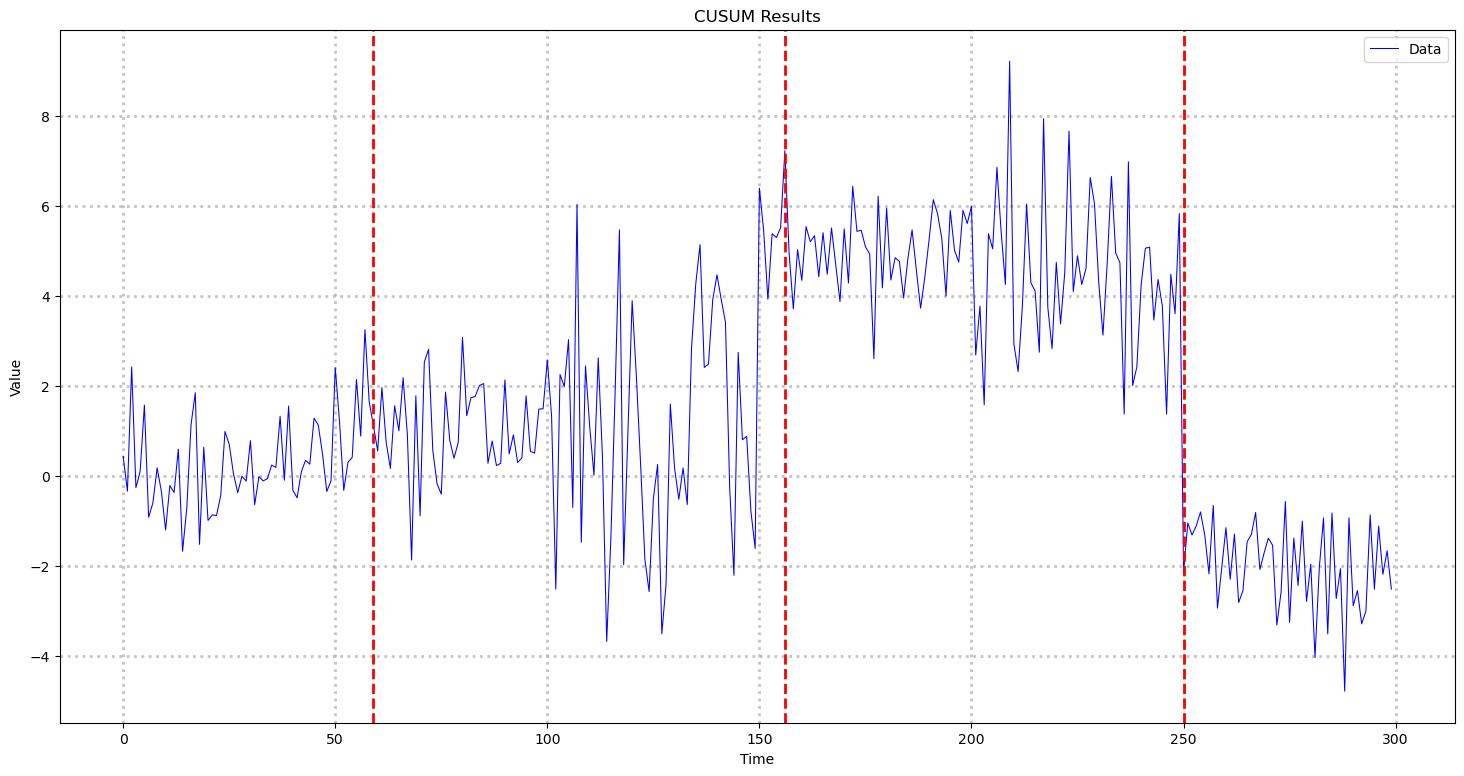

2024-07-08 14:13:33.546 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=16.368181)
2024-07-08 14:13:33.590 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=11.981057)
2024-07-08 14:13:33.648 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=18.893876)
2024-07-08 14:13:33.698 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=43.929834)


{'value2': array([ 59, 156, 250], dtype=int64)}

In [12]:
test.plot_cusum(a, ['value2'])